# Settings

In [2]:
import numpy as np
import sys
import pandas as pd
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import zivot_andrews
from statsmodels.regression.linear_model import OLS

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp
from tigramite.plotting import plot_time_series_graph

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

import cdsapi
import random
import zipfile

import netCDF4 as nc
import xarray as xr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.subplots as sp

import seaborn as sns

from arch.unitroot import PhillipsPerron
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import f

import networkx as nx

from scipy.stats import pearsonr

import dagviz
from collections import Counter

from tqdm import tqdm

import nbformat

import pingouin as pg

import chow_test 
from chow_test import chow_test

/Users/juliette/anaconda3/envs/envEmma/lib/python3.9/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Functions: Generating Dataset

## Random VAR(p) model

In [3]:
def CompanionFormMatrix(phi, seed=None):
    
    #if seed is not None:
    #    np.random.seed(seed)
    
    p, n, _ = phi.shape
    C = np.zeros((n * p, n * p))

    # Fill in the Phi matrices
    for i in range(p):
        C[:n, i*n:(i+1)*n] = phi[i]

    # Fill in the identity matrices
    for i in range(1, p):
        C[i*n:(i+1)*n, (i-1)*n:i*n] = np.eye(n)
    
    # Check the eigenvalues
    eigenvalues = np.linalg.eigvals(C)
    abs_eigenvalues = np.abs(eigenvalues)
    score = 0
    for i in range(0,len(abs_eigenvalues)):
        if abs_eigenvalues[i] > 1:
                score += 1
    
    if score == 0:
        stability = True
        text = 'The system is stable'
    else:
        stability = False
        text = 'The system is not stable'        
        
    return C, stability, text, abs_eigenvalues

In [4]:
def Generate_VARp_Model(n, p, T, s, beta=0.01, gamma=0.01, diagonal=True, standard=True, constant=False, seed=None):
    """
    This function creates a dataset based on a random VAR(p).
    Note that it follows the definitions of VAR-models from literature: rows are variables.
    
    n: the number of variables
    p: the number of time-lags that the model uses to influence current t
    T: the total number of time-periods in the final dataset
    s: the sparseness of the model; denseness of the edges
    beta: the divergence from zero of the off-diagonal values in Phi        
    gamma: the divergence from one of the diagonal values in Phi
    diagonal: if True, then the diagonal consists of values close to 1 (+/- gamma)
    standard: if True then the error terms are generated by a standard normal process
    constant: if False, then the constant term only consists of zeros
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    "Phi"
    # First we generate a 3D array and run through all of it to assign a 0 or 1
    StableSystem = False
    while StableSystem == False:
        Phi = np.zeros((p, n, n))
        for lag in range(p):            # Run over all lags
            for i in range(n):          # Run over all rows
                for j in range(n):      # Run over all columns
                    Phi[lag, i, j] = np.random.binomial(1,s)
        # Then we run through it again to replace the 1's with a uniform entry
        for lag in range(p):
            for i in range(n):
                for j in range(n):
                    if Phi[lag, i, j] == 1:
                        Phi[lag, i, j] = np.random.uniform(0-beta, 0+beta) #<-- deze was eerste. -1, 1 en 0.02
        # Finally we run through the entries of Phi and make sure the diagonal is 1+the random generated number
        if diagonal == True:
            for t in range(p):
                for i in range(n):
                    for j in range(n):
                        if i==j:
                            Phi[t, i, j] = np.random.uniform(1-gamma, 1+gamma)    #<<-- ineens niet meer stable? ook al zit het in de loop! (deze was 0.05)
        # In the last step we check whether it is a stable system. Otherwise we generate a new one.
        C, stable, stable_text, eigenvalues = CompanionFormMatrix(Phi, seed)
        if stable == True:
            StableSystem = True    
    
    
    "Error term"
    # Make sure we generate from a Gaussian White Noise woth a diagonal covariance matrix
    # We can choose the matrix to be equal to the identity matrix to generate a standard normal distribution 
    # Or we can choose it to be any other diagonal matrix.
    if standard==True:
        Sigma = np.eye(n)
        epsilon = np.random.multivariate_normal(np.zeros(n), Sigma, T).T
    else:
        Sigma = np.diag(np.random.uniform(-1, 1, n))  # Or choose (0, 1, n)!
        epsilon = np.random.multivariate_normal(np.zeros(n), Sigma, T).T 
    
    "Constant term"
    # Set up the constant term, and only fill in the values when constant==True
    if constant==True:
        C = np.random.randn(n, T)
    else:
        C = np.zeros((n, T))
    
    "Time series"
    # Initialize our time series matrix with values at t = 0, ..., p
    # We set the values between 30 and 40 because of reality, but can be chosen randomly
    Y = np.zeros((n,T))
    Y[:, :p] = np.random.uniform(30, 40, (n, p))

    for t in range(p,T):
        for i in range(n):
            Y[i,t] += C[i,t-p]
            # for i = 0 vullen we dus eigenlijk Y_1t, dan vullen we Y_2t, etc. en later gaan we pas naar andere t
            for j in range(1,p+1):
                for k in range(n):
                    Y[i,t] += (Phi[j-1][i,k])*(Y[k,t-j])
            Y[i,t] += epsilon[i,t-p]

    return Y, Phi, Sigma, eigenvalues

In [5]:
def GenerateDF_VARp_Model(data, start_year, column_names="NONE"):
    """
    This function generates a dataframe that we can use easily. 
    It will transpose the dataset so that we have rows of years and columns of variables, instead of the other way around.
    """
    
    # Make it a df and transpose the dataset (needed for Tigramite)
    df = pd.DataFrame(data)
    df = df.T
    
    # Generate the names for the columns and rows
    #rows = list(range(start_year, start_year + df.shape[0]))  <--- yearly
    rows = pd.date_range(start=f'{start_year}-01', periods=df.shape[0], freq='ME')
    if column_names=="NONE":
        columns = [chr(65 + i) for i in range(df.shape[1])]
    else:
        columns = column_names
    
    # Assign the names to the columns and rows
    df.index = rows
    df.columns = columns
    
    # We will also be using a Tigramite df so let's return that as well
    # Note that a Tigramite dataframe needs to be of size Txn 
    dfT = pp.DataFrame(df.values, var_names=df.columns.tolist(), datatime=df.index.tolist())

    return df, dfT

## VAR(p) model based on a phi

In [6]:
def CheckStability(phi):
    """
    Function to check the stability as definned by Lutkepohl (2005). 
    All eigenvalues of matrix phi (if p=1) should have modulus smaller than one.
    """
    
    eigenvalues = np.linalg.eigvals(phi)
    abs_eigenvalues = np.abs(eigenvalues)
    
    score = 0
    for i in range(len(abs_eigenvalues)):
        if abs_eigenvalues[i] > 1:
            score += 1
    
    if score == 0:
        stability = True
    else:
        stability = False
    
    return stability

In [7]:
def Error(phi, T, standard=True, seed=None):
    """
    Generate an error term with the same length as the phi matrix of the problem.
    """
    if seed is not None:
        np.random.seed(seed)
    
    n = len(phi)  
    
    if standard:
        sigma = np.eye(n)
    else:
        sigma = np.diag(np.random.uniform(-1, 1, n))
    
    epsilon = np.random.multivariate_normal(np.zeros(n), sigma, T).T
    
    return epsilon, sigma

In [8]:
def Constant(phi, constant_term=False, seed=None):
    """
    Generate a constant term with the same length as the phi matrix of the problem.
    """
    
    if seed is not None:
        np.random.seed(seed)

    n = len(phi)  
    
    if constant_term:
        C = np.random.randn(n,1)
    else:
        C = np.zeros((n,1))
    
    return C

In [9]:
def Time_Series(phi, C, epsilon, T, initial_mean, initial_var, seed=None):
    """
    Generate time series based on an input phi matrix, constant and error term.
    initial_mean: list/array of means for each variable
    initial_variance: list/array of variances for each variable
    """
    if seed is not None:
        np.random.seed(seed)

    n = len(phi)  
    Y = np.zeros((n, T))
    # We initialize the time series with a random normal variable form the initial mean and variance as input.
    for i in range(n):
        Y[i, 0] = np.random.normal(initial_mean[i], initial_var[i]) 
    
    for t in range(1,T):
        for i in range(n):
            Y[i,t] += C[i] # Add the constant
            for j in range(n):
                Y[i,t] += (phi[i,j])*(Y[j,t-1]) # Add the phi-term
            Y[i,t] += epsilon[i,t-1] # Add the error

    return Y

In [10]:
def GenerateVAR(phi, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None):
    """
    Bring all the functions together so we can run it with just one click.
    """
    
    "Check stability of Phi matrix"
    stability = CheckStability(phi)
    if stability == False:
        print("WARNING: please note that the input phi matrix is not stable.")
        #print("The input Phi is stable!")

    "Generate Error Term"
    epsilon, sigma = Error(phi, T, standard=standard_error_distribution, seed=seed)
    
    "Generate Constant Term"
    C = Constant(phi, constant_term=constant_term, seed=seed)
    
    "Generate Time Series"
    Y = Time_Series(phi, C, epsilon, T, initial_mean, initial_var, seed=seed)
    
    return Y, C, epsilon, sigma

In [11]:
def GenerateDF(data, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW']):
    """
    This function generates a dataframe that we can use easily. 
    It will transpose the dataset so that we have rows of years and columns of variables, instead of the other way around.
    """
    
    # Make it a df and transpose the dataset (needed for Tigramite)
    df = pd.DataFrame(data)
    df = df.T
    
    if yearly == True:
        rows = list(range(2015-len(df), 2015))
    # Generate the names for the columns and rows
    #rows = list(range(start_year, start_year + df.shape[0]))  <--- yearly
    else:
        rows = pd.date_range(start=f'1982-01', periods=df.shape[0], freq=freq)  
        
    # Assign the names to the columns and rows
    df.index = rows
    df.columns = column_names
    
    # We will also be using a Tigramite df so let's return that as well
    # Note that a Tigramite dataframe needs to be of size Txn 
    dfT = pp.DataFrame(df.values, var_names=df.columns.tolist(), datatime=df.index.tolist())

    return df, dfT

In [12]:
def ConstructPhiMatrix(val_matrix):
    "Construct a Phi Matrix for the pcmci option based on an input val_matrix"
    n, _, _ = val_matrix.shape # Or just fill in 4
    Phi = np.zeros((n,n))
    for i in range(0,n): 
        for j in range(0,n): 
            Phi[i,j] = val_matrix[j,i,1]
    return Phi

# Functions: PCMCI

In [13]:
def Run_PCMCI_Original(data, parcorr, tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.01, extended = 0, model = 'model'):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        data = data[:,:3]

        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dfT = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)

        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        data = data[:,:4]

        
        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dfT = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        tw_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
        
        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': tw_detrend})
            
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dfT = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        tw_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df['NHF'], show_plot = False)
        
        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': tw_detrend,
                                        'NHF': nhf_detrend})
            
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    dfT_processed = pp.DataFrame(np.copy(df_processed), datatime = {0:np.arange(len(df_processed))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dfT_processed, cond_ind_test=parcorr,verbosity=0)
    results = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
    # Plot the graph
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI')
    plt.title(f'Causal networks based on complete history of {model} data', fontsize = 18)
    plt.show()
    
    return results

In [14]:
def Generate_Initial_Phi(n, seed=None):
    """
    Remains unused furthermore!
    """
    if seed is not None:
        np.random.seed(seed)
    
    Phi = np.zeros((n,n))
    stable_system = False
    while not stable_system:
        for i in range(4):
            for j in range(4):
                if i == j:
                    Phi[i,j] = np.random.uniform(0.8, 1.2)
                else:
                    Phi[i,j] = np.random.uniform(-1, 1)
        stable = CheckStability(Phi)
        if stable:
            stable_system = True

    return Phi

In [15]:
def Run_PCMCI(df, parcorr, tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05, var_names = ['WPAC', 'CPAC', 'EPAC', 'TW'], period=12, model = 'model'):

    cpac_detrend = deTrend_deSeasonalize(df['CPAC'], period=period, show_plot = False)
    epac_detrend = deTrend_deSeasonalize(df['EPAC'], period=period, show_plot = False)
    wpac_detrend = deTrend_deSeasonalize(df['WPAC'], period=period, show_plot = False)
    tw_detrend = deTrend_deSeasonalize(df['TW'], period=period, show_plot = False)
    
    df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend, 'TW': tw_detrend})
            
    # Construct mask for spring barrier
    springbarrier_mask = SpringBarrierMask(df_processed, period)
    
    dfT = pp.DataFrame(np.copy(df_processed), datatime = {0:np.arange(len(df_processed))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dfT, cond_ind_test=parcorr,verbosity=0)
    results = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
    # Plot the graph
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI')
    plt.title(f'Causal networks based on complete history of {model} data', fontsize = 18)
    plt.show()
    
    return results

In [16]:
def Run_PCMCI_yearly(df, parcorr, tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05, var_names = ['WPAC', 'CPAC', 'EPAC', 'TW'], model = 'model', plot=True):

    cpac_detrend = deTrend_deSeasonalize(df['CPAC'], period=12, show_plot = False)
    epac_detrend = deTrend_deSeasonalize(df['EPAC'], period=12, show_plot = False)
    wpac_detrend = deTrend_deSeasonalize(df['WPAC'], period=12, show_plot = False)
    tw_detrend = deTrend_deSeasonalize(df['TW'], period=12, show_plot = False)
    
    df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend, 'TW': tw_detrend})
            
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
        
    dfT = pp.DataFrame(np.copy(df_processed), datatime = {0:np.arange(len(df_processed))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dfT, cond_ind_test=parcorr,verbosity=0)
    results = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
    if plot==True:
        # Plot the graph
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI')
        plt.title(f'Causal networks based on {model} data', fontsize = 18)
        plt.show()
    
    return results

In [17]:
def Run_PCMCI_VAR(data, test, pc_alpha=0.05, alpha_level=0.05, tau_max=1, tau_min=0, plot_graph=True, name=""):
    """
    data: DataFrame!
    PC_alpha: Significance level in algorithm.
    Alpha_level: Significance level at which the p_matrix is thresholded to get graph.
    Tau_max: Maximum time lag. Must be larger or equal to tau_min.
    Tau_min: Minimum time lag to test. Note that zero-lags are undirected
    """
    values = data.values
    time_indices = np.arange(len(data))
    variable_names = data.columns.tolist()
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(data.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    df = pp.DataFrame(values, var_names=variable_names, datatime=time_indices, mask = springbarrier_mask)
    
    cond_ind_test = test
    pcmci = PCMCI(dataframe=df, cond_ind_test=test, verbosity=0)
    pcmci.alpha = pc_alpha
    pcmci.tau_max = tau_max
    results = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh') 
    # We could add: fdr_method = 'fdr_bh'. However this method is also the default method so we can erase it.
    
    if plot_graph == True:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        tp.plot_graph(
            fig_ax=(fig, ax),
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=variable_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI'
        )
        ax.set_title(f'Tigramite PCMCI outcome - {name} - Process Graph')
        plt.show()
    
    
    return results,df

In [18]:
def Run_PCMCI_VAR_ALTERNATIVE(data, test, pc_alpha=0.05, alpha_level=0.05, tau_max=1, tau_min=0, plot_graph=True, name=""):
    """
    data: DataFrame!
    PC_alpha: Significance level in algorithm.
    Alpha_level: Significance level at which the p_matrix is thresholded to get graph.
    Tau_max: Maximum time lag. Must be larger or equal to tau_min.
    Tau_min: Minimum time lag to test. Note that zero-lags are undirected
    """
    values = data.values
    time_indices = np.arange(len(data))
    variable_names = data.columns.tolist()
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(data.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    df = pp.DataFrame(np.copy(data), datatime=time_indices, var_names=variable_names, mask = springbarrier_mask)
    
    cond_ind_test = test
    pcmci = PCMCI(dataframe=df, cond_ind_test=test, verbosity=0)
    #pcmci.alpha = pc_alpha
    #pcmci.tau_max = tau_max
    results = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh') 
    # We could add: fdr_method = 'fdr_bh'. However this method is also the default method so we can erase it.
    
    if plot_graph == True:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        tp.plot_graph(
            fig_ax=(fig, ax),
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=variable_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI'
        )
        ax.set_title(f'Tigramite PCMCI outcome - {name} - Process Graph')
        plt.show()
    
    return results,df

In [19]:
parcorr = ParCorr(significance='analytic', mask_type='y')
parcorr_nomask = ParCorr(significance='analytic')
parcorr_conf = ParCorr(significance='analytic', mask_type='y', confidence='analytic', conf_lev=0.9, conf_samples=100)

In [20]:
def Generate_Initial_Phi(n, seed=None):
    """
    Remains unused furthermore!
    """
    if seed is not None:
        np.random.seed(seed)
    
    Phi = np.zeros((n,n))
    stable_system = False
    while not stable_system:
        for i in range(4):
            for j in range(4):
                if i == j:
                    Phi[i,j] = np.random.uniform(0.8, 1.2)
                else:
                    Phi[i,j] = np.random.uniform(-1, 1)
        stable = CheckStability(Phi)
        if stable:
            stable_system = True

    return Phi

In [21]:
def ConstructPhiMatrixBagging(mean_val_matrix):
    "Construct a Phi Matrix for the bagging option based on an input mean val_matrix"
    n, _, _ = mean_val_matrix.shape # Or just fill in 4
    Phi = np.zeros((n,n))
    for i in range(0,n): 
        for j in range(0,n): 
            Phi[i,j] = mean_val_matrix[j,i,1]
    return Phi

In [22]:
def GenerateVARBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None):
    
    "Construct a Phi matrix"
    phi = ConstructPhiMatrixBagging(mean_val_matrix)
    "Construct the data"
    Y, C, epsilon, sigma = GenerateVAR(phi, T, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed)
    
    return Y, C, epsilon, sigma

In [23]:
def Run_Bagging(df, tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot=True, model=''):
        
    cpac_detrend = deTrend_deSeasonalize(df['CPAC'], period=12, show_plot = False)
    epac_detrend = deTrend_deSeasonalize(df['EPAC'], period=12, show_plot = False)
    wpac_detrend = deTrend_deSeasonalize(df['WPAC'], period=12, show_plot = False)
    tw_detrend = deTrend_deSeasonalize(df['TW'], period=12, show_plot = False)
    
    df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend, 'TW': tw_detrend})
    
    var_names = df.columns.tolist()
    
    df_tigramite = pp.DataFrame(df.values,
                                datatime=np.arange(df.shape[0]),
                                var_names=var_names)
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    #Now let's run it:
    
    pcmci = PCMCI(dataframe=df_tigramite,
        cond_ind_test=test,
        verbosity=0,
        )
    
    results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)
    
    if plot == True:
        # Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
        boot_linkfreq = results['summary_results']['link_frequency']
        boot_graph = results['summary_results']['most_frequent_links']
        val_mat = results['summary_results']['val_matrix_mean']
    
        tp.plot_graph(
            graph = boot_graph,
            val_matrix= val_mat,
            link_width = boot_linkfreq,
            var_names=df_tigramite.var_names,
            )
        plt.title(f'Causal networks using Bagging based on {model} data', fontsize=16)
        plt.show()
        
    return results

In [24]:
def MakeData_RunBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None, 
                        plot_data=True, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], 
                        tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot_DAG=True, model=''):
    
    "Generate a VAR model based on the outcome of bagging on the basemodel"
    # We generate a var using our function based on the mean_val_matrix that was output of the basemodel
    # And using the means and variances that fit the data of the basemodel
    # We also transform this into dataframes
    Y, C, epsilon, sigma = GenerateVARBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed)
    df, dfT = GenerateDF(Y, yearly=yearly, freq=freq, column_names=column_names)
    
    "Plot the data if wished for"
    if plot_data == True:
        fig = px.line(df, x=df.index, y=df.columns, title=f'Time Series Plot of Variables - Bagging Data based on seed={seed}')
        fig.show()
    
    "Run the bagging function to return the results of the bagging model"
    results = Run_Bagging(df, tau_max=tau_max, boot_samples=boot_samples, boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot=plot_DAG, model=model)

    return results, df, dfT, Y, C, epsilon, sigma

In [25]:
def MakeData_RunBagging_ComparisonStatistic(mean_val_matrix, ci_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None, 
                        plot_data=True, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], 
                        tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot_DAG=True, model=''):
    
    "Generate a model and run bagging"
    results, df, dfT, Y, C, epsilon, sigma = MakeData_RunBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed, 
                        plot_data=plot_data, yearly=yearly, freq=freq, column_names=column_names, 
                        tau_max=tau_max, boot_samples=boot_samples, boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot_DAG=plot_DAG, model=model)
    val_matrix = results['summary_results']['val_matrix_mean']
    
    "Generate the Comparison Statistic"
    comparison_statistic, check = ComparisonStatistic(ci_matrix_bagging_climate, val_matrix)
    
    return comparison_statistic, results, df, dfT, Y, C, epsilon, sigma, check

# Functions: Correctness Statistic

In [26]:
def ComparisonStatistic(baseline_conf_matrix, val_matrix):
    """
    AKA: Correctness Statistic
    This function can be used to develop a statistic that explains how much of the input val_matrix explains the baseline val_matrix correctly.
    It now only checks whether it falls within the confidence bounds, 
    but could also be extended to include how close it is to the real value in baseline_val_matrix.
    """
    
    n, _, _ = val_matrix.shape
        
    check = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            value = val_matrix[j,i,1]
            lower_bound = baseline_conf_matrix[j,i,1,0]
            upper_bound = baseline_conf_matrix[j,i,1,1]
            if (value > lower_bound) and (value < upper_bound):
                check[j, i] = 1
    
    correct = np.count_nonzero(check == 1)
    stats = (correct / check.size) * 100
    
    return stats, check

In [27]:
def CorrectnessStatisticMC(M, baseline_conf_matrix, baseline_val_matrix, t, initial_mean, initial_var, parcorr, tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05):
    
    phi = ConstructPhiMatrix(baseline_val_matrix)
    all_stats = []
    
    for i in tqdm(range(M), desc="Monte Carlo Simulations Progress"):
        data, _, _, _ = GenerateVAR(phi, t+100, initial_mean, initial_var, seed=None) 
        df_full, _ = GenerateDF(data, yearly=True)
        df = df_full.iloc[100:]
        
        results = Run_PCMCI_yearly(df, parcorr, tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05, var_names = ['WPAC', 'CPAC', 'EPAC', 'TW'], model = '', plot=False)
        value_matrix = results['val_matrix']
        
        stat, _ = ComparisonStatistic(baseline_conf_matrix, value_matrix)
        all_stats.append(stat)
    
    
    correctness_statistic = np.mean(all_stats, axis=0)
    
    return correctness_statistic

In [28]:
def Seed_Generator(l, lower_bound=1, upper_bound=1000000):
    unique_seeds = set()
    while len(unique_seeds) < l:
        new_seed = np.random.randint(lower_bound, upper_bound)
        unique_seeds.add(new_seed)
    return list(unique_seeds)

In [29]:
def Run_and_Compare_PCMCI(phi, initial_mean, initial_var, conf_matrix, parcorr, intervals=50, min_T=50, max_T=100000, plot=False, plot_graph=True, print_loading=True, seed=None):
    """
    Values
    """
    
    l = (max_T - min_T)//intervals
    statistics = np.zeros((l,2))
    i = 0
    
    if seed == None:
        unique_seeds = Seed_Generator(l)
    else:
        unique_seeds = [seed]*l
    
    for t in range(min_T, max_T, intervals):
        if seed==None:
            s = unique_seeds[i]
            data, _, _, _ = GenerateVAR(phi, t+100, initial_mean, initial_var, seed=s) 
        else:
            data, _, _, _ = GenerateVAR(phi, t+100, initial_mean, initial_var, seed=seed) 

        df_full, _ = GenerateDF(data, yearly=True)
        df = df_full.iloc[100:]
        
        results = Run_PCMCI_yearly(df, parcorr, tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05, var_names = ['WPAC', 'CPAC', 'EPAC', 'TW'], model = f'T={t}', plot=plot)
        value_matrix = results['val_matrix']
        
        stat, correct_matrix = ComparisonStatistic(conf_matrix, value_matrix)
        
        statistics[i,0] = t
        statistics[i,1] = stat
        
        if print_loading == True: 
            if i%20 ==0:
                print(f"loading... {np.round(((i+1)/l)*100)}%")
        
        i += 1
    
    df = pd.DataFrame(statistics, columns=['T','Statistic Value'])
    df.set_index('T', inplace=True)
    
    fig = px.line(df, x=df.index, y=df.columns, title='Correctness Statistic')
    fig.update_layout(yaxis_title='% within confidence bounds')
    fig.update_layout(xaxis_title='Number of time periods T in dataset')
    # Add the trend line to the plot
    x = df.index.values
    y = df['Statistic Value'].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(x=x, y=p(x), mode='lines', name='Trend Line', line=dict(color='grey', dash='dash')))
    
    if plot_graph == True:
        fig.show()
    
    return statistics, df, fig, unique_seeds

In [30]:
def MonteCarlo_PCMCI_CSgraph(val_matrix, ci_matrix, initial_mean, initial_var, M, test, intervals=50, min_T=50, 
                            max_T=10000, plot_dags=False, plot_graphs=False, seed=None):
    """
    First of all this function constructs a Phi matrix based on the input val_matrix.
    The input val_matrix is the baseline val_matrix that estimates the underlying problem. 
    Second, the function constructs a dataset based on this Phi, runs PCMCI on this dataset and compares it to the baseline ci_matrix.
    The percentage of values in the new val_matrix that are within the baseline conf_matrix is given as statistic.
    Thirdly, we run this for several length of the dataset T and construct a graph.
    Fourth, this process is repeated M times and the mean represents the Monte Carlo statistic.
    """
    
    l = (max_T - min_T)//intervals
    
    MCstatistics = np.zeros((l, M+1)) 
    dataframes = {}
    seeds = {} # deze
    
    Phi = ConstructPhiMatrix(val_matrix)
    
    for m in tqdm(range(M), desc="Monte Carlo Simulations Progress"):
        comp_stats, df_sim, _, seeds_sim = Run_and_Compare_PCMCI(Phi, initial_mean, initial_var, ci_matrix, test, intervals=intervals, min_T=min_T, max_T=max_T, plot=plot_dags, plot_graph=plot_graphs, print_loading=False, seed=seed)
        MCstatistics[:,m+1] = comp_stats[:,1]
        dataframes[f'df_m_{m}'] = df_sim  # Save each dataframe in the dictionary
        seeds[f'seed_m_{m}'] = seeds_sim  # Save each list of seeds in the dictionary
        print(f"loading... {np.round(((m+1)/M)*100)}%")

    # And use the last iteration of the statistics to save indeces in the first column of MCstatistics
    MCstatistics[:,0] = comp_stats[:,0]
    
    # Now we will calculate the mean values and store that in a matrix as well
    means = np.mean(MCstatistics[:, 1:], axis=1)
    mean_values = np.zeros((l,2))
    mean_values[:,0] = MCstatistics[:,0]
    mean_values[:,1] = means
    
    # Finally we plot the figure
    fig = go.Figure()
    colors = px.colors.sequential.Blues
    # Plot lines for each column in MCstatistics (except for the first, which has the indeces)
    for i in range(1, M+1):
        fig.add_trace(go.Scatter(x=MCstatistics[:, 0], y=MCstatistics[:, i],
                             mode='lines', line=dict(color=colors[i % len(colors)]),
                             name=f'Sim {i}', showlegend=False))
        
    # Plot the mean value line, which will be our MC statistic
    fig.add_trace(go.Scatter(x=mean_values[:, 0], y=mean_values[:, 1],
                         mode='lines', 
                         line=dict(color='red'),
                         name='Mean Correctness Statistic'))
    # Calculate and plot the trend line
    z = np.polyfit(mean_values[:, 0], mean_values[:, 1], 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(x=mean_values[:, 0], y=p(mean_values[:, 0]),
                         mode='lines', 
                         line=dict(color='black', dash='dash'),
                         name='Trend Line'))
    # Finish up and plot the graph
    fig.update_layout(title=f'Correctness Statistic (based on PCMCI with {M} simulations)',
                  xaxis_title='Number of time periods T in dataset',
                  yaxis_title='% within confidence bounds')
    fig.show()
    
    return MCstatistics, fig, dataframes, seeds

In [31]:
def CheckDuplicateSeeds(seed_dictionary):

    """
    Checks whether there are duplicate seeds in a certain index in the list. 
    If there are, we have generated a duplicate dataframe. 
    If a big part of our simulations are duplicates, then this may influence the results.
    """

    # Initialize a list of defaultdicts to store counts for each index
    index_counts = [defaultdict(int) for _ in range(max(len(v) for v in seed_dictionary.values()))]

    # Fill in the values
    for key, values in seed_dictionary.items():
        for i, value in enumerate(values):
            index_counts[i][value] += 1

    # Check for duplicates in each index of the lists
    duplicate_count = 0
    for i, counts in enumerate(index_counts):
        index_duplicates = sum(count - 1 for count in counts.values() if count > 1)
        # And if the index has any duplicates, print it!
        if index_duplicates > 0:
            print(f"Index {i} has {index_duplicates} duplicates.")
        duplicate_count += index_duplicates
    print(f"Total number of duplicates in the same list index: {duplicate_count}")

# Functions: Reversed Correctness Statistic

In [32]:
def Phi_in_ConfBounds(initial_phi, estimated_conf):
    """
    This function looks a lot like the correctness statistic.
    However, we do it the other way round: is the initial phi within the estimated confidence interval?
    If so, that is a success!
    """
    
    n, _ = initial_phi.shape
        
    check = np.zeros((n,n))
    bound_lengths = []
    for i in range(n):
        for j in range(n):
            value = initial_phi[i,j]
            lower_bound = estimated_conf[j,i,1,0]
            upper_bound = estimated_conf[j,i,1,1]
            diff_bound = upper_bound - lower_bound
            bound_lengths.append(diff_bound)
            if (value > lower_bound) and (value < upper_bound):
                check[j,i] = 1
    mean_bound_lengths = np.mean(bound_lengths)         
    return check, mean_bound_lengths

In [33]:
def ReversedCorrectnessStatistic_for_Phi(initial_phi, estimated_conf):
    check, mean_bound_lengths = Phi_in_ConfBounds(initial_phi, estimated_conf)
    correct = np.count_nonzero(check == 1)
    rev_corr_stat = (correct / check.size) * 100
    
    return rev_corr_stat, check, mean_bound_lengths

In [34]:
def Run_and_Compare_PCMCI_Reversed(initial_phi, initial_mean, initial_var, parcorr, intervals=50, min_T=50, max_T=100000, plot=False, plot_graph=True, print_loading=True, seed=None):
    """
    Values
    """
    
    l = (max_T - min_T)//intervals
    statistics = np.zeros((l,2))
    i = 0
    bound_lengths = np.zeros((l,2))
    
    if seed == None:
        unique_seeds = Seed_Generator(l)
    else:
        unique_seeds = [seed]*l
        
    for t in range(min_T, max_T, intervals):
        # Generate dataset and dataframe
        s = unique_seeds[i]
        data, _, _, _ = GenerateVAR(initial_phi, t+100, initial_mean, initial_var, seed=s) 
        df_full, _ = GenerateDF(data, yearly=True)
        df = df_full.iloc[100:]
        # Run PCMCI
        results = Run_PCMCI_yearly(df, parcorr, tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05, var_names = ['WPAC', 'CPAC', 'EPAC', 'TW'], model = f'T={t}', plot=plot)
        value_matrix = results['val_matrix']
        conf_matrix = results['conf_matrix']
        
        stat, correct_matrix, mean_bound_lengths = ReversedCorrectnessStatistic_for_Phi(initial_phi, conf_matrix)
        
        statistics[i,0] = t
        statistics[i,1] = stat

        bound_lengths[i,0] = t
        bound_lengths[i,1] = mean_bound_lengths
        
        if print_loading == True: 
            if i%20 ==0:
                print(f"loading... {np.round(((i+1)/l)*100)}%")
        
        i += 1
    
    df = pd.DataFrame(statistics, columns=['T','Statistic Value'])
    df.set_index('T', inplace=True)
    
    fig = px.line(df, x=df.index, y=df.columns, title='Reversed Correctness Statistic')
    fig.update_layout(yaxis_title='% within confidence bounds')
    fig.update_layout(xaxis_title='Number of time periods T in dataset')
    # Add the trend line to the plot
    x = df.index.values
    y = df['Statistic Value'].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(x=x, y=p(x), mode='lines', name='Trend Line', line=dict(color='black', dash='dash')))
    
    if plot_graph == True:
        fig.show()
    
    return statistics, df, fig, unique_seeds, bound_lengths

In [35]:
def MonteCarlo_PCMCI_RCSgraph(val_matrix, initial_mean, initial_var, M, test, intervals=50, min_T=50, 
                            max_T=10000, plot_dags=False, plot_graphs=False, seed=None):
    """
    First of all this function constructs a Phi matrix based on the input val_matrix.
    The input val_matrix is the baseline val_matrix that estimates the underlying problem. 
    Second, the function constructs a dataset based on this Phi, runs PCMCI on this dataset and compares it to the baseline ci_matrix.
    The percentage of values in the new val_matrix that are within the baseline conf_matrix is given as statistic.
    Thirdly, we run this for several length of the dataset T and construct a graph.
    Fourth, this process is repeated M times and the mean represents the Monte Carlo statistic.
    """
    
    l = (max_T - min_T)//intervals
    
    MCstatistics = np.zeros((l, M+1)) 
    dataframes = {}
    seeds = {} # deze
    all_mean_bound_lengths = []
    
    Phi = ConstructPhiMatrix(val_matrix)
    for m in range(M):
        comp_stats, df_sim, _, seeds_sim, bound_lengths = Run_and_Compare_PCMCI_Reversed(Phi, initial_mean, initial_var, test, intervals=intervals, min_T=min_T, max_T=max_T, plot=plot_dags, plot_graph=plot_graphs, print_loading=False, seed=seed)
        MCstatistics[:,m+1] = comp_stats[:,1]
        all_mean_bound_lengths.append(bound_lengths)
        dataframes[f'df_m_{m}'] = df_sim  # Save each dataframe in the dictionary
        seeds[f'seed_m_{m}'] = seeds_sim  # Save each list of seeds in the dictionary
        print(f"loading... {np.round(((m+1)/M)*100)}%")
        
    # And use the last iteration of the statistics to save indeces in the first column of MCstatistics
    MCstatistics[:,0] = comp_stats[:,0]
    
    # Now we will calculate the mean values and store that in a matrix as well
    means = np.mean(MCstatistics[:, 1:], axis=1)
    mean_values = np.zeros((l,2))
    mean_values[:,0] = MCstatistics[:,0]
    mean_values[:,1] = means
        
    # Finally we plot the figure
    fig = go.Figure()
    colors = px.colors.sequential.Blues
    # Plot lines for each column in MCstatistics (except for the first, which has the indeces)
    for i in range(1, M+1):
        fig.add_trace(go.Scatter(x=MCstatistics[:, 0], y=MCstatistics[:, i],
                             mode='lines', line=dict(color=colors[i % len(colors)]),
                             name=f'Sim {i}'))
        
    # Plot the mean value line, which will be our MC statistic
    fig.add_trace(go.Scatter(x=mean_values[:, 0], y=mean_values[:, 1],
                         mode='lines', 
                         line=dict(color='red'),
                         name='MC statistic'))
    # Calculate and plot the trend line
    z = np.polyfit(mean_values[:, 0], mean_values[:, 1], 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(x=mean_values[:, 0], y=p(mean_values[:, 0]),
                         mode='lines', 
                         line=dict(color='black', dash='dash'),
                         name='Trend Line'))
    # Finish up and plot the graph
    fig.update_layout(title=f'Reversed Correctness Statistic (based on PCMCI with {M} simulations)',
                  xaxis_title='Number of time periods T in dataset',
                  yaxis_title='% within confidence bounds')
    fig.show()
    
    # We will also work with the mean bound lengths
    times = all_mean_bound_lengths[0][:, 0]
    conf_intervals = np.array([array[:, 1] for array in all_mean_bound_lengths])
    mean_conf_intervals = np.mean(conf_intervals, axis=0)
    fig2 = go.Figure()
    for i, conf_interval in enumerate(conf_intervals):
        fig2.add_trace(go.Scatter(x=times, y=conf_interval, mode='lines', name=f'Array {i+1}'))
    fig2.add_trace(go.Scatter(x=times, y=mean_conf_intervals, mode='lines', name='Mean', line=dict(width=4, dash='dash')))
    fig2.update_layout(
        title='Confidence Intervals and Mean',
        xaxis_title='Time Period',
        yaxis_title='Confidence Interval Length',
        legend_title='Legend'
    )
    fig2.show()
    
    return MCstatistics, fig, dataframes, seeds, all_mean_bound_lengths

In [36]:
def MC_ReversedCorrectnessStatistic(M, T, s=0.75, beta=0.6, gamma=0.5, test=parcorr_conf, diagonal=True, 
                                            standard=True, constant=False, pc_alpha=0.05, alpha_level=0.01, 
                                            tau_max=1, tau_min=1, plot_graph=False, name_plot = 'simulated', seed=None):
    
    MCstatistics = []
    for m in range(M):
        "Construct data"
        # First we create a random VAR(p) model 
        data, initial_phi, _, _ = Generate_VARp_Model(4, 1, T, s, beta=beta, gamma=gamma, 
                                                                            diagonal=diagonal, standard=standard, 
                                                                            constant=constant, seed=seed)
        df, dfT = GenerateDF(data, 1982)
        # Then calculate its means and variances
        means = [np.mean(data[0]), (data[1]), np.mean(data[2]), np.mean(data[3])]
        variances = [(np.std(data[0])**2), (np.std(data[1])**2), (np.std(data[2])**2), (np.std(data[3])**2)]
        
        "Run PCMCI"
        results, _ = Run_PCMCI_VAR(df, test, pc_alpha=pc_alpha, alpha_level=alpha_level, tau_max=tau_max, tau_min=tau_min, plot_graph=plot_graph, name = name_plot)
        estimated_conf = results['conf_matrix']
        
        "Compute reversed correctness statistic"
        rev_corr_stat, check_matrix = ReversedCorrectnessStatistic_for_Phi(initial_phi[0], estimated_conf)                                         
        MCstatistics.append(rev_corr_stat)
    
    MCRevCorrStat = np.mean(MCstatistics)

    return MCRevCorrStat

In [37]:
def MC_ReversedCorrectnessStatistic_for_Phi(Phi, initial_mean, initial_var, M, T,  test=parcorr_conf, 
                                            constant_term=False, standard_error_distribution=True, pc_alpha=0.05, alpha_level=0.01, 
                                            tau_max=1, tau_min=1, plot_graph=False, name_plot = 'simulated', seed=None):
    
    MCstatistics = []
    
    for m in range(M):
        "Construct data"
        # First we create a random VAR(p) model 
        data, _, _, _ = GenerateVAR(Phi, T, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed)
        df, dfT = GenerateDF(data, 1982)
        # Then calculate its means and variances
        #means = [np.mean(data[0]), (data[1]), np.mean(data[2]), np.mean(data[3])]
        #variances = [(np.std(data[0])**2), (np.std(data[1])**2), (np.std(data[2])**2), (np.std(data[3])**2)]
        
        "Run PCMCI"
        results, _ = Run_PCMCI_VAR(df, test, pc_alpha=pc_alpha, alpha_level=alpha_level, tau_max=tau_max, tau_min=tau_min, plot_graph=plot_graph, name = name_plot)
        estimated_conf = results['conf_matrix']
        
        "Compute reversed correctness statistic"
        rev_corr_stat, check_matrix = ReversedCorrectnessStatistic_for_Phi(Phi, estimated_conf)                                         
        MCstatistics.append(rev_corr_stat)
    
    MCRevCorrStat = np.mean(MCstatistics)
    
    return MCRevCorrStat

# Basemodel: Climate Data

In [38]:
start_year = 1950
length = 12*(2022 - start_year)

### WPAC = Sea level pressure (in Pa) in the West Pacific

In [39]:
WPAC = np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [40]:
mean_WPAC = np.mean(WPAC)
std_dev_WPAC = np.std(WPAC)
median_WPAC = np.median(WPAC)
min_val_WPAC = np.min(WPAC)
max_val_WPAC = np.max(WPAC)

print("Mean:", mean_WPAC)
print("Standard Deviation:", std_dev_WPAC)
print("Median:", median_WPAC)
print("Minimum Value:", min_val_WPAC)
print("Maximum Value:", max_val_WPAC)

Mean: 100934.85266203702
Standard Deviation: 93.61832329131148
Median: 100938.0
Minimum Value: 100659.9
Maximum Value: 101247.5


In [41]:
start_year = 1950
end_year = 2022
plot_length = 12 * (end_year - start_year + 1)
time_index = pd.date_range(start=f'{start_year}-01', periods=plot_length, freq='MS')
time_index = time_index[:len(WPAC)]

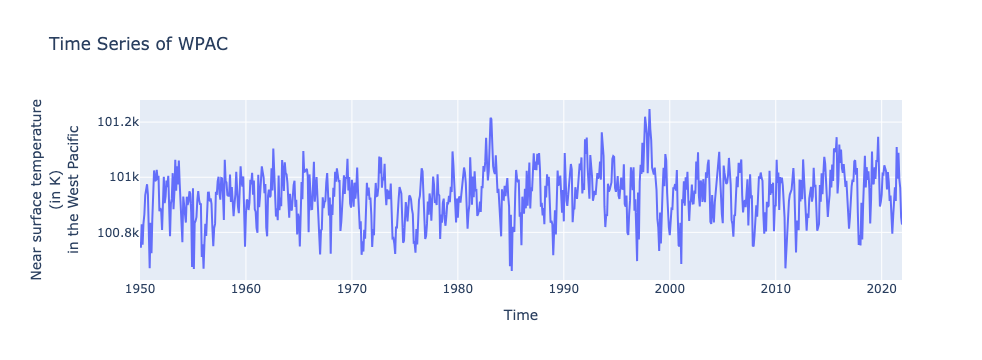

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=WPAC, mode='lines', name='WPAC'))
fig.update_layout(
    title='Time Series of WPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the West Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

### CPAC = Near surface temperature (in K) in the Central Pacific

In [43]:
CPAC = np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [44]:
mean_CPAC = np.mean(CPAC)
std_dev_CPAC = np.std(CPAC)
median_CPAC = np.median(CPAC)
min_val_CPAC = np.min(CPAC)
max_val_CPAC = np.max(CPAC)

print("Mean:", mean_CPAC)
print("Standard Deviation:", std_dev_CPAC)
print("Median:", median_CPAC)
print("Minimum Value:", min_val_CPAC)
print("Maximum Value:", max_val_CPAC)

Mean: 298.8509971064815
Standard Deviation: 0.8447594851404049
Median: 298.91795
Minimum Value: 296.1973
Maximum Value: 300.8865


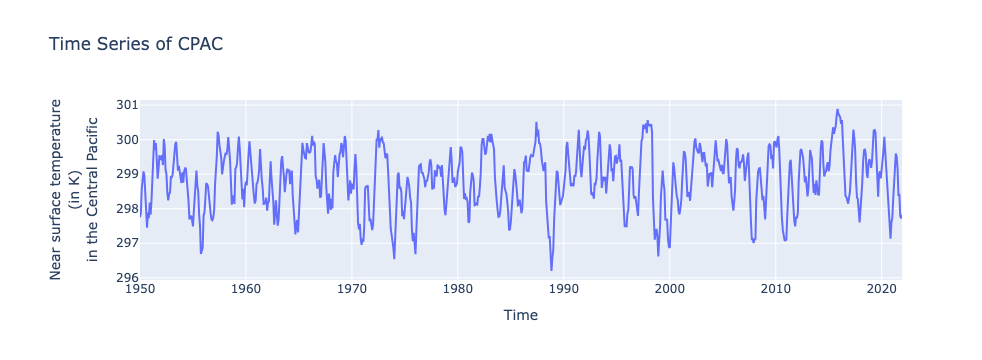

In [45]:
time_index = time_index[:len(CPAC)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=CPAC, mode='lines', name='CPAC'))
fig.update_layout(
    title='Time Series of CPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

### EPAC = Near surface temperature (in K) in the East Pacific

In [46]:
EPAC = np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [47]:
mean_EPAC = np.mean(EPAC)
std_dev_EPAC = np.std(EPAC)
median_EPAC = np.median(EPAC)
min_val_EPAC = np.min(EPAC)
max_val_EPAC = np.max(EPAC)

print("Mean:", mean_EPAC)
print("Standard Deviation:", std_dev_EPAC)
print("Median:", median_EPAC)
print("Minimum Value:", min_val_EPAC)
print("Maximum Value:", max_val_EPAC)

Mean: 296.9792201388889
Standard Deviation: 1.5031017287062765
Median: 296.94034999999997
Minimum Value: 293.807
Maximum Value: 300.8609


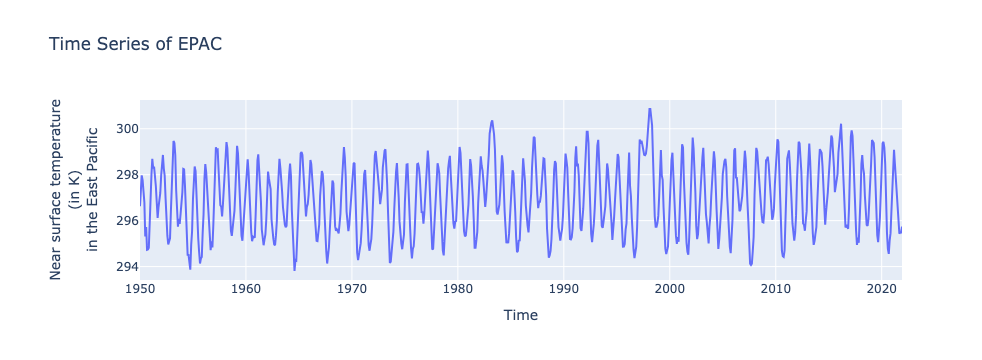

In [48]:
time_index = time_index[:len(EPAC)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=EPAC, mode='lines', name='EPAC'))
fig.update_layout(
    title='Time Series of EPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the East Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

### TW = Near surface winds (in m/s) in the Central Pacific

In [49]:
TW = np.loadtxt('iera5_u10m_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]
TW *= -1 

In [50]:
mean_TW = np.mean(TW)
std_dev_TW = np.std(TW)
median_TW = np.median(TW)
min_val_TW = np.min(TW)
max_val_TW = np.max(TW)

print("Mean:", mean_TW)
print("Standard Deviation:", std_dev_TW)
print("Median:", median_TW)
print("Minimum Value:", min_val_TW)
print("Maximum Value:", max_val_TW)

Mean: 5.440672281446759
Standard Deviation: 1.0029878863066852
Median: 5.5784445
Minimum Value: -0.3439944
Maximum Value: 7.407164


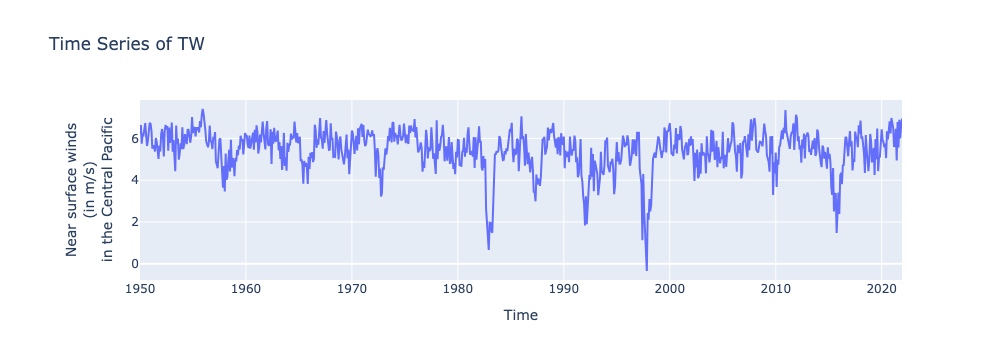

In [51]:
time_index = time_index[:len(TW)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=TW, mode='lines', name='TW'))

fig.update_layout(
    title='Time Series of TW',
    xaxis_title='Time',
    yaxis_title='Near surface winds<br>(in m/s)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)

fig.show()

### Extended Dataset and lists

In [52]:
extended_data = np.vstack((
    WPAC,
    CPAC,
    EPAC,
    TW
                )).T

In [53]:
means_climate = [mean_WPAC, mean_CPAC, mean_EPAC, mean_TW]
variances_climate = [(std_dev_WPAC**2), (std_dev_CPAC**2), (std_dev_EPAC**2), (std_dev_TW**2)]

In [54]:
print(means_climate)
print(variances_climate)

[100934.85266203702, 298.8509971064815, 296.9792201388889, 5.440672281446759]
[8764.390455876513, 0.7136185877346819, 2.2593148068397966, 1.005984700077952]


## Detrending and deseazonalizing

In [55]:
def deTrend_deSeasonalize(data, period=12, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=period) # 1 for annual, 12 for monthly, 52 for weekly and 365 for daily
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    #smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        #plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data #- smoothed
        return result

## Full History Reanalysis PCMCI Outcome

### The output graph

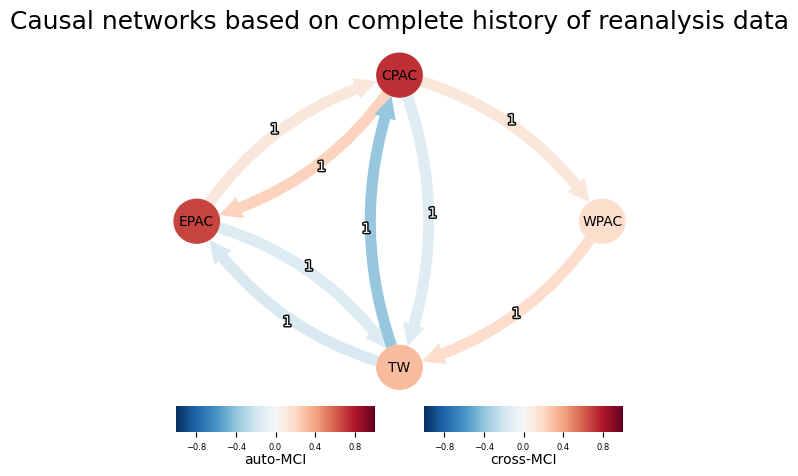

In [56]:
# Run_PCMCI_Original(data, parcorr, tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.01, extended = 0, info = True, model = 'model')
four_node_complete_history_reanalysis_results_climate = Run_PCMCI_Original(extended_data, parcorr, tau_max=1, tau_min=1, extended=1, model = 'reanalysis')

### The output data

In [57]:
value_matrix_climate = four_node_complete_history_reanalysis_results_climate['val_matrix']

In [58]:
ci_matrix_climate = four_node_complete_history_reanalysis_results_climate['conf_matrix']

For more information, see ComparisonStatistic.ipynb

In [59]:
phi_climate = ConstructPhiMatrix(value_matrix_climate)
print(phi_climate)
eigenvalues_phi_climate = np.linalg.eigvals(phi_climate)
print(eigenvalues_phi_climate)

[[ 0.17373507  0.11975307  0.02447545  0.04915396]
 [ 0.07074018  0.73161387  0.11135553 -0.38836812]
 [-0.00390825  0.23154391  0.67338652 -0.16276586]
 [ 0.18385259 -0.12399532 -0.13851116  0.31312003]]
[0.04489187 0.97844968 0.37025159 0.49826235]


## New Correctness Statistic

In [95]:
new_cs = CorrectnessStatisticMC(10000, ci_matrix_climate, value_matrix_climate, 864, means_climate, variances_climate, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [22:40<00:00,  7.35it/s]

80.980625


In [97]:
new_cs2 = CorrectnessStatisticMC(10000, ci_matrix_climate, value_matrix_climate, 2000, means_climate, variances_climate, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs2)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [38:33<00:00,  4.32it/s] 

86.49875


In [98]:
new_cs3 = CorrectnessStatisticMC(10000, ci_matrix_climate, value_matrix_climate, 432, means_climate, variances_climate, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs3)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [18:28<00:00,  9.02it/s]


69.939375


# Basemodel: Random VAR Model

## Generating and plotting the data

In [60]:
data_VAR, phi_VAR, sigma_VAR, eigenvalues_VAR = Generate_VARp_Model(4, 1, 964, 0.75, beta=0.6, gamma=0.5, diagonal=True, standard=True, constant=False, seed=654)
#def Generate_VARp_Model(n, p, T, s, beta=0.01, gamma=0.01, diagonal=True, standard=True, constant=False, seed=None):
# Beta: how much do the non-diagonal elements diverge from 0
# Gamma: how much do the diagonal elements diverge from 1
# We generate a VAR model that is similar to the climate data (one lag and 4 variables with 864 observations).

In [61]:
df_full, dfT_VAR = GenerateDF(data_VAR, 1982)
df_VAR = df_full[100:]

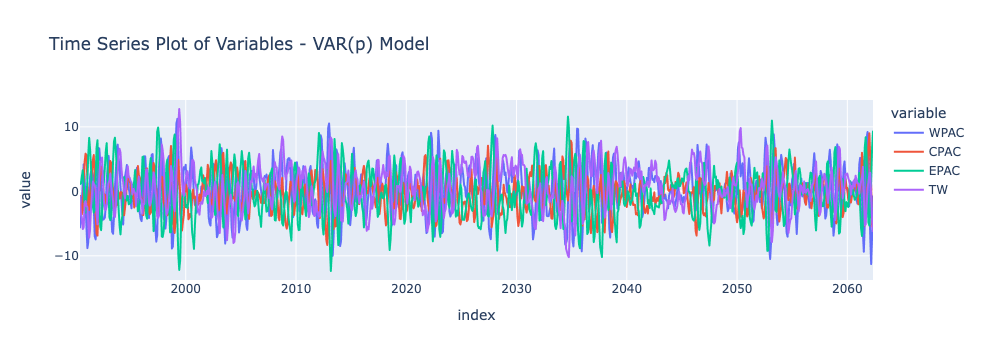

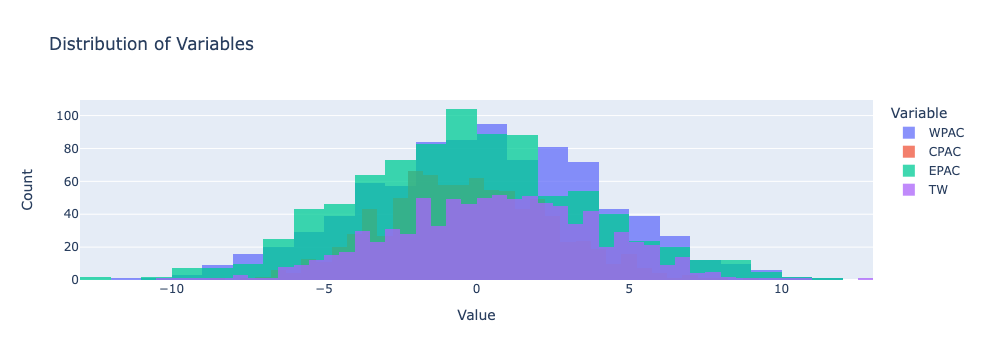

[[[ 0.79034116 -0.56096917  0.29970999  0.        ]
  [ 0.4371717   0.69850643 -0.16777062 -0.38686567]
  [-0.5726033  -0.0828862   0.70228068  0.        ]
  [ 0.39338768  0.          0.09488778  0.79573702]]]


In [62]:
fig = px.line(df_VAR, x=df_VAR.index, y=df_VAR.columns, title='Time Series Plot of Variables - VAR(p) Model')
fig.show()
fig = go.Figure()
for column in df_VAR.columns:
    fig.add_trace(go.Histogram(x=df_VAR[column], name=column, opacity=0.75))
fig.update_layout(
    barmode='overlay',
    title='Distribution of Variables',
    xaxis_title='Value',
    yaxis_title='Count',
    legend_title='Variable'
)
fig.show()
print(phi_VAR)

In [63]:
mean_WPAC_var = np.mean(data_VAR[0])
mean_CPAC_var = np.mean(data_VAR[1])
mean_EPAC_var = np.mean(data_VAR[2])
mean_TW_var = np.mean(data_VAR[3])
means_VAR = [mean_WPAC_var, mean_CPAC_var, mean_EPAC_var, mean_TW_var]

In [64]:
std_dev_WPAC_var = np.std(data_VAR[0])
std_dev_CPAC_var = np.std(data_VAR[1])
std_dev_EPAC_var = np.std(data_VAR[2])
std_dev_TW_var = np.std(data_VAR[3])

variances_VAR = [(std_dev_WPAC_var**2), (std_dev_CPAC_var**2), (std_dev_EPAC_var**2), (std_dev_TW_var**2)]

## Full History Reanalysis PCMCI Outcome

### The output graph

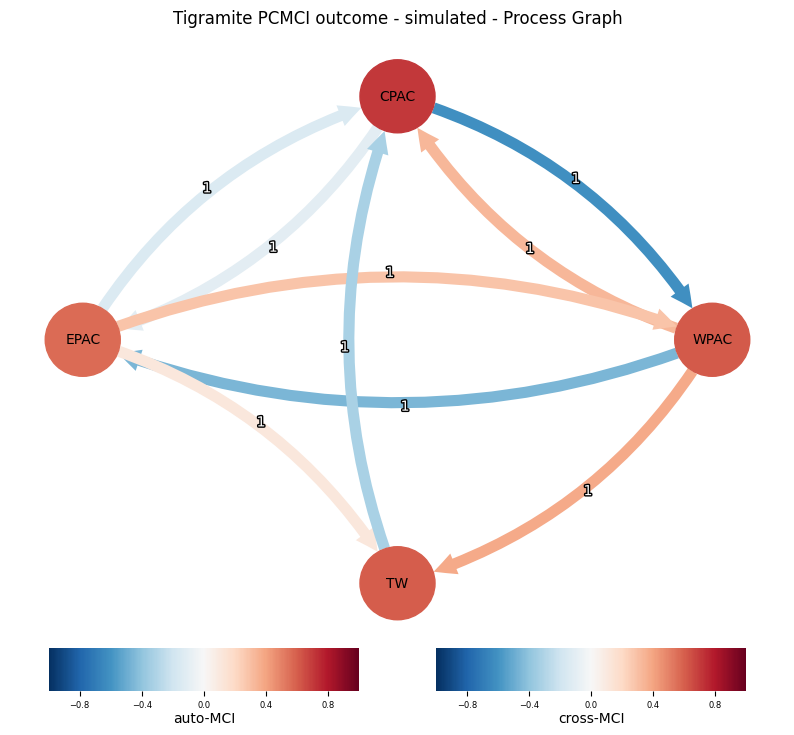

[[[ 0.79034116 -0.56096917  0.29970999  0.        ]
  [ 0.4371717   0.69850643 -0.16777062 -0.38686567]
  [-0.5726033  -0.0828862   0.70228068  0.        ]
  [ 0.39338768  0.          0.09488778  0.79573702]]]


In [65]:
# Note that we use a different PCMCI function because now we do not deseazonalize
four_node_complete_history_results_VAR,  four_node_complete_history_results_VAR_df = Run_PCMCI_VAR(df_VAR, parcorr_conf, pc_alpha=0.05, alpha_level=0.01, tau_max=1, tau_min=1, name = 'simulated')
# Run_PCMCI_VAR(data, test, pc_alpha=0.05, alpha_level=0.05, tau_max=1, tau_min=0, plot_graph=True, name=""):
# results_Bjerknes = runPCMCItigramite(df_Bjerknes, RobustParCorr(), pc_alpha=0.1, alpha_level=0.05, plot_graph=True, name="DF Bjerknes all data")
print(phi_VAR)

### The output data

In [66]:
value_matrix_VAR = four_node_complete_history_results_VAR['val_matrix']

In [67]:
ci_matrix_VAR = four_node_complete_history_results_VAR['conf_matrix']

In [69]:
print(value_matrix_VAR)
val_VAR_654 = ConstructPhiMatrixBagging(value_matrix_VAR)
print(val_VAR_654)

[[[ 0.          0.61117375]
  [ 0.          0.33386788]
  [ 0.         -0.46086702]
  [ 0.          0.38193518]]

 [[ 0.         -0.61590335]
  [ 0.          0.70992956]
  [ 0.         -0.10829027]
  [ 0.          0.05832271]]

 [[ 0.          0.2837045 ]
  [ 0.         -0.14514207]
  [ 0.          0.56394209]
  [ 0.          0.11325743]]

 [[ 0.         -0.02136648]
  [ 0.         -0.32213139]
  [ 0.          0.04952168]
  [ 0.          0.60538578]]]
[[ 0.61117375 -0.61590335  0.2837045  -0.02136648]
 [ 0.33386788  0.70992956 -0.14514207 -0.32213139]
 [-0.46086702 -0.10829027  0.56394209  0.04952168]
 [ 0.38193518  0.05832271  0.11325743  0.60538578]]


Since there is no conf matrix computed, we will make confidence bounds ourselves.

In [116]:
def Construct_CI_matrix(val_matrix, alpha):
    """
    Construct your own CI matrix by giving an input val-matrix.
    """
    n, _, _ = val_matrix.shape
    conf_matrix = np.zeros((n,n,2,2))
    
    for i in range(n):
        for j in range(n):
            value = val_matrix[j,i,1]
            lower_bound = value - alpha
            upper_bound = value + alpha
            conf_matrix[j,i,1,0] = lower_bound
            conf_matrix[j,i,1,1] = upper_bound
    return conf_matrix

In [117]:
ci_matrix_VAR_comp = Construct_CI_matrix(value_matrix_VAR, 0.01)

## New Correctness Statistic

In [107]:
new_cs4 = CorrectnessStatisticMC(10000, ci_matrix_VAR, value_matrix_VAR, 432, means_VAR, variances_VAR, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs4)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [18:00<00:00,  9.25it/s]

54.744375


In [118]:
new_cs5 = CorrectnessStatisticMC(10000, ci_matrix_VAR, value_matrix_VAR, 864, means_VAR, variances_VAR, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs5)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [22:25<00:00,  7.43it/s]


61.26


In [119]:
new_cs6 = CorrectnessStatisticMC(10000, ci_matrix_VAR, value_matrix_VAR, 2000, means_VAR, variances_VAR, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs6)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [37:10<00:00,  4.48it/s] 


65.26625


## Comparing the output phi with the underlying phi

First we construct a new Phi corresponding to the underlying model, which will later on be used to construct simulation data when running PCMCI and monte carlo. However, since there were no confidence bounds, and since we are interested in learning more about the loss of information when running PCMCI, we first compare the new Phi to the underlying Phi.

In [71]:
phi_VAR_second = ConstructPhiMatrix(value_matrix_VAR)

### Comparison of initial and output Phi

Let us compare the Phi matrices from before and after PCMCI. 

In [72]:
print("Phi matrix before PCMCI (phi_VAR) on which the dataset was based that was used in PCMCI:")
print(phi_VAR)
print("Phi matrix after PCMCI (phi_VAR_second):")
print(phi_VAR_second)

Phi matrix before PCMCI (phi_VAR) on which the dataset was based that was used in PCMCI:
[[[ 0.79034116 -0.56096917  0.29970999  0.        ]
  [ 0.4371717   0.69850643 -0.16777062 -0.38686567]
  [-0.5726033  -0.0828862   0.70228068  0.        ]
  [ 0.39338768  0.          0.09488778  0.79573702]]]
Phi matrix after PCMCI (phi_VAR_second):
[[ 0.60975461 -0.53491269  0.23588566 -0.01381425]
 [ 0.39897259  0.57724803 -0.18865383 -0.34772134]
 [-0.50289904 -0.0339156   0.5800986   0.04060771]
 [ 0.43240649  0.02457022  0.09606289  0.63183455]]


We could do the reverse of the correctness statistic, namely looking at whether or not the new confidence bounds capture the old phi. In the correctness statistic, we checked whether or not the estimated phi matrix lies within the confidence bounds of the initial one.

In [73]:
ReversedCorrectnessStatistic, CheckMatrix = ReversedCorrectnessStatistic_for_Phi(phi_VAR[0], ci_matrix_VAR)
print(ReversedCorrectnessStatistic)

ValueError: too many values to unpack (expected 2)

Only 62.5% of the initial phi values are in the confidence intervals of the newly estimated VAR!

In [74]:
mean_RCS = MC_ReversedCorrectnessStatistic_for_Phi(phi_VAR[0], means_VAR, variances_VAR, 100, 2000,  test=parcorr_conf, 
                                            constant_term=False, standard_error_distribution=True, pc_alpha=0.05, alpha_level=0.01, 
                                            tau_max=1, tau_min=1, plot_graph=False, name_plot = 'simulated', seed=None)
print(mean_RCS)

ValueError: too many values to unpack (expected 2)

So we see that 62.5% correctness is actually pretty good, relative to other seeds.

In [75]:
def Difference_in_Phi(baseline_phi, second_phi, alpha, print_results=True, plot_graphs=True):
    """
    Let's check the similarity between the two phi matrices. How much information is lost in the PCMCI algorithm?
    """
    
    n, _ = second_phi.shape
    
    # Assuming phi_VAR and phi_VAR_second are your matrices
    # Compute element-wise difference
    absolute_difference = second_phi - baseline_phi
    
    # Relative difference
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_difference = np.divide(absolute_difference, baseline_phi) * 100
        relative_difference[baseline_phi == 0] = np.inf  # or another suitable value
    
    # And we will also check if they are more than alpha from the true value
    check_map = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if absolute_difference[i,j] > alpha or absolute_difference[i,j] < -alpha:
                check_map[i,j] = 1
    
    # Compute Frobenius norm of the difference 
    # We know this from the bachelor as Euclidean norm!
    frobenius_norm = np.linalg.norm(absolute_difference, 'fro')

    # Compute Mean Absolute Error (MAE)
    mae = np.mean(np.abs(absolute_difference))
    
    # Print the results
    if print_results == True:
        print(f"Frobenius Norm of Difference: {frobenius_norm}")
        print(f"Mean Absolute Error: {mae}")

    # Visual comparison using heatmaps
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    sns.heatmap(absolute_difference, cmap="coolwarm", annot=True)
    plt.title('Difference in absolute values')
    
    plt.subplot(1, 3, 2)
    sns.heatmap(relative_difference, cmap="coolwarm", annot=True)
    plt.title('Difference in relative values')
    
    plt.subplot(1, 3, 3)
    sns.heatmap(check_map, cmap="coolwarm", annot=True)
    plt.title('Binary indication of exceeding threshold alpha')
    
    plt.tight_layout()
    if plot_graphs == True:
        plt.show()
    
    return absolute_difference, relative_difference, frobenius_norm, mae

Frobenius Norm of Difference: 0.32941127712739154
Mean Absolute Error: 0.06336861811229688


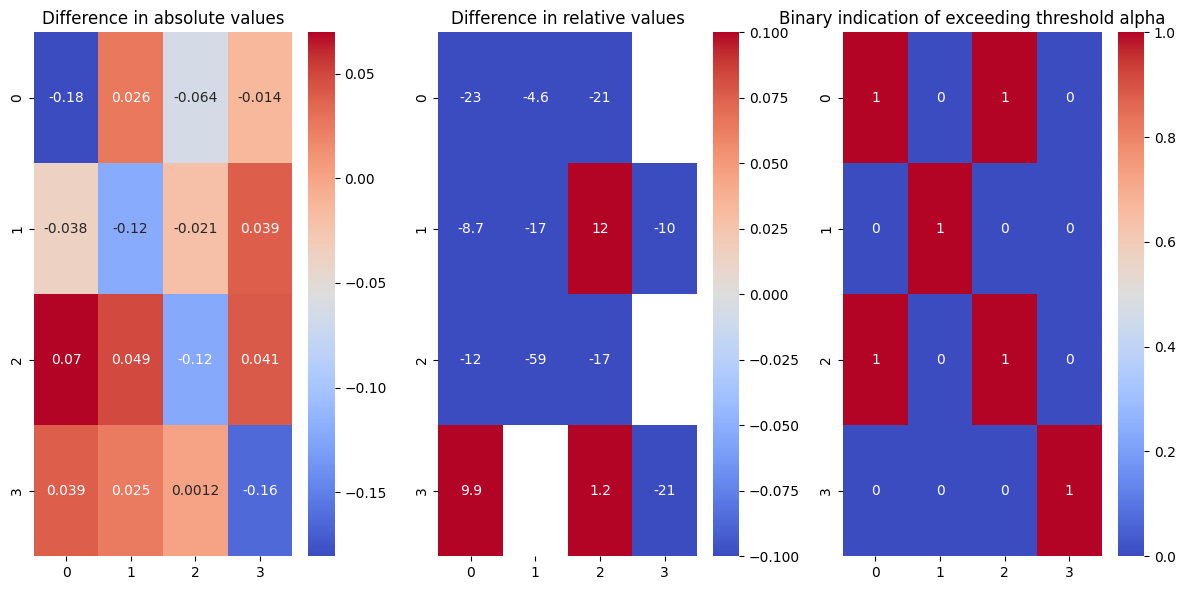

In [76]:
abs_dif_VAR, rel_dif_VAR, eucladian_VAR, mae_VAR = Difference_in_Phi(phi_VAR[0], phi_VAR_second, 0.05)

### Phi Comparison Statistic

So we have an initial Phi called phi_VAR, on which we based a certain dataset. We then ran the pcmci algorithm and got an output val_matrix on which we based our output Phi called phi_VAR_second. Now we would like to know how similar these two matrices are to see how much information goes lost within the PCMCI algorithm. This could explain some of the low percentage of confidence intervals in the 'correctness statistic' that we later on compute. 

The process of plotting the graphs and comparing them could be repeated for a number of data lengths and multiple times (Monte Carlo) to see the effect of different dataset lengths, specifically as a mean value.

In [77]:
def FrobeniusNorm(absolute_difference_matrix):
    frob_norm = np.linalg.norm(absolute_difference_matrix, 'fro')
    return frob_norm

In [78]:
def MeanAbsoluteError(absolute_difference_matrix):
    # Compute Mean Absolute Error (MAE)
    mae = np.mean(np.abs(absolute_difference_matrix))
    return mae

In [79]:
def GenerateData_and_ComparePhi(initial_phi, initial_mean, initial_var, T, test=parcorr_conf, pc_alpha=0.05, alpha_level=0.01, tau_max=1, tau_min=1, name = 'simulated', seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    "Construction and estimation"
    # First construct a dataset based on the first phi
    data, _, _, _ = GenerateVAR(initial_phi, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=seed)
    df, dfT = GenerateDF(data)
    # Then run PCMCI
    results,  results_df = Run_PCMCI_VAR(df, test, pc_alpha=pc_alpha, alpha_level=alpha_level, tau_max=tau_max, tau_min=tau_min, plot_graph=False, name = name)
    # And construct an 'after' phi matrix 
    second_phi = ConstructPhiMatrix(results['val_matrix'])
    second_conf = results['conf_matrix']
        
    "Statistics"
    # Assuming phi_VAR and phi_VAR_second are your matrices
    # Compute element-wise difference
    absolute_difference = second_phi - initial_phi
    # Relative difference
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_difference = np.divide(absolute_difference, initial_phi) * 100
        relative_difference[initial_phi == 0] = np.inf 
    # Check map
    check_map = Phi_in_ConfBounds(initial_phi, second_conf)
    # Frobenius Norm
    frob_norm = FrobeniusNorm(absolute_difference)
    # Mean Absolute Error
    mae = MeanAbsoluteError(absolute_difference)
    
    return absolute_difference, relative_difference, check_map, frob_norm, mae

In [80]:
def MonteCarloTests_PhiComparisonStatistic(initial_phi, initial_mean, initial_var, M, T, test=parcorr_conf, pc_alpha=0.05, alpha_level=0.01, tau_max=1, tau_min=1, name = 'simulated', seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    
    # First generate lists to store everything in.
    abs_diff_list = []
    rel_diff_list = []
    check_map_list = []
    frob_norm_list = []
    mae_list = []
    
    # Then simulate M times:
    for m in range(M):
        abs_diff, rel_diff, check_map, frob_norm, mae = GenerateData_and_ComparePhi(initial_phi, 
                                                                                    initial_mean, 
                                                                                    initial_var, T, test=test, 
                                                                                    pc_alpha=pc_alpha, 
                                                                                    alpha_level=alpha_level, 
                                                                                    tau_max=tau_max, tau_min=tau_min, 
                                                                                    name = name, seed=seed)

        abs_diff_list.append(abs_diff)
        rel_diff_list.append(rel_diff)
        check_map_list.append(check_map)
        frob_norm_list.append(frob_norm)
        mae_list.append(mae)
    
    # Finally compute the means of every list
    mean_abs_diff = np.mean(abs_diff_list, axis=0)
    mean_rel_diff = np.mean(rel_diff_list, axis=0)
    mean_check_map = np.mean(check_map_list, axis=0)
    mean_frob_norm = np.mean(frob_norm_list)
    mean_mae = np.mean(mae_list)
    
    # Now we can print the results and plot the graphs
    print(f"Frobenius Norm of Difference: {mean_frob_norm}")
    print(f"Mean Absolute Error: {mean_mae}")

    # Visual comparison using heatmaps
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    sns.heatmap(mean_abs_diff, cmap="coolwarm", annot=True)
    plt.title(f'Difference in absolute values')
    
    plt.subplot(1, 3, 2)
    sns.heatmap(mean_rel_diff, cmap="coolwarm", annot=True)
    plt.title(f'Difference in relative values')
    
    plt.subplot(1, 3, 3)
    sns.heatmap(mean_check_map, cmap="coolwarm", annot=True)
    plt.title(f'Binary indication of baseline phi within confidence intervals')
    
    plt.tight_layout()
    plt.title(f'Statistics for {M} simulations with a length of T={T}')
    plt.show()
    
    return mean_abs_diff, mean_rel_diff, mean_check_map, mean_frob_norm, mean_mae

Frobenius Norm of Difference: 0.33998996003459664
Mean Absolute Error: 0.0637330267646235


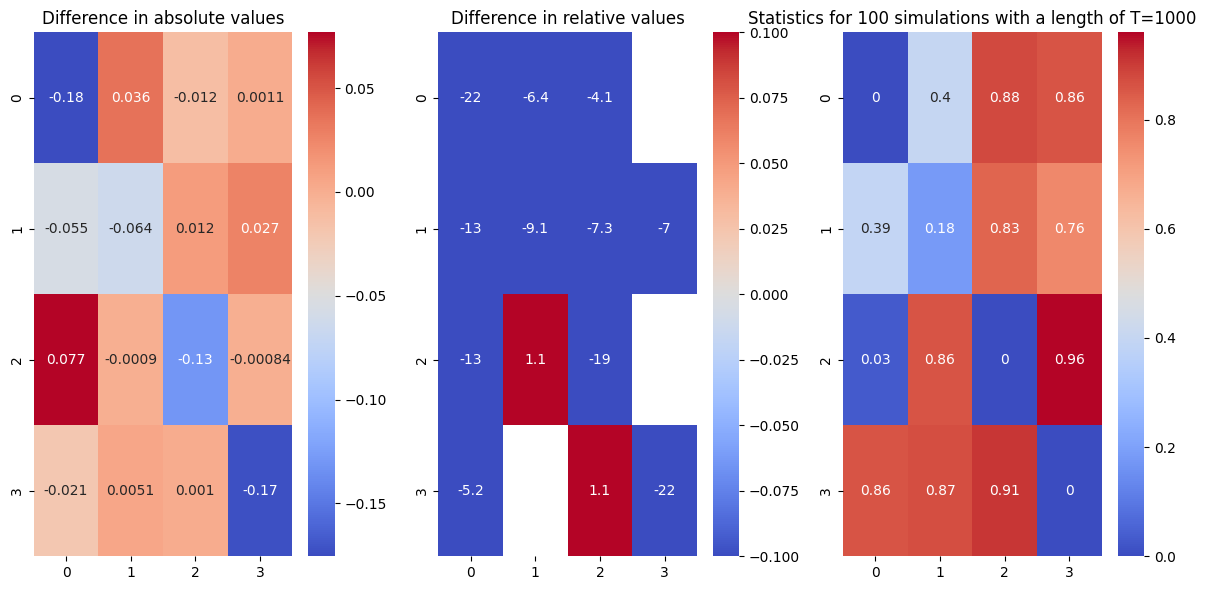

In [553]:
_, _, _, _, _ = MonteCarloTests_PhiComparisonStatistic(phi_VAR[0], means_VAR, variances_VAR, 100, 1000, test=parcorr_conf, pc_alpha=0.05, alpha_level=0.01, tau_max=1, tau_min=1, name = 'simulated', seed=None)
# Remember: it is within the confidence bounds if it is 1, so for the most right matrix, we have that the red is good

## New Correctness Statistic

In [80]:
new_cs_random = CorrectnessStatisticMC(10000, ci_matrix_VAR, value_matrix_VAR, 864, means_VAR, variances_VAR, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs_random)
#new_cs = CorrectnessStatisticMC(10000, ci_matrix_climate, value_matrix_climate, 864, means_climate, variances_climate, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [22:16<00:00,  7.48it/s]

62.0


In [83]:
new_cs_random2 = CorrectnessStatisticMC(10000, ci_matrix_VAR, value_matrix_VAR, 2000, means_VAR, variances_VAR, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs_random2)

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [38:09<00:00,  4.37it/s]

63.42625


In [81]:
new_cs_random3 = CorrectnessStatisticMC(10000, ci_matrix_VAR, value_matrix_VAR, 600, means_VAR, variances_VAR, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(new_cs_random3) #TILLIE HIER WAS JE

Monte Carlo Simulations Progress: 100%|██████████| 10000/10000 [19:00<00:00,  8.76it/s]


59.8


# Results: Monte Carlo Simulations of Climate Data

loading... 10.0%


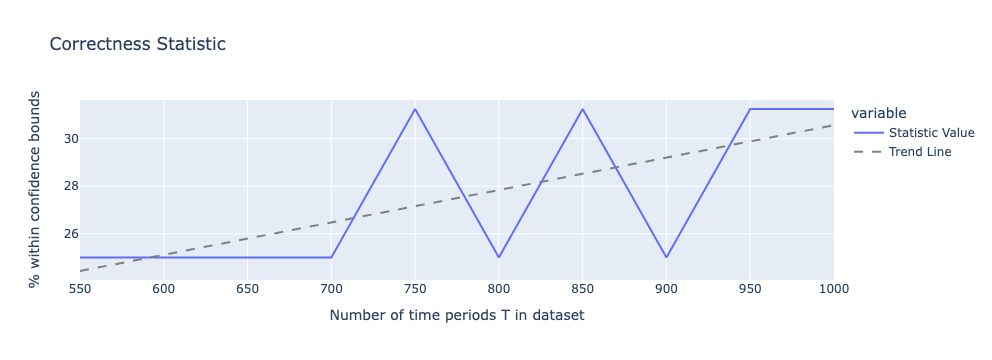

In [166]:
statistics_climate, _, _, siets = Run_and_Compare_PCMCI(phi_climate, means_climate, variances_climate, ci_matrix_climate, ParCorr(), intervals=50, min_T=550, max_T=1050, plot=False, seed=None)


In [167]:
print(siets)

[42080, 73670, 49148, 16465, 68598, 93691, 78778, 25467, 9628, 60541]


loading... 1.0%
loading... 2.0%
loading... 3.0%
loading... 4.0%
loading... 5.0%
loading... 6.0%
loading... 7.0%
loading... 8.0%
loading... 9.0%
loading... 10.0%
loading... 11.0%
loading... 12.0%
loading... 13.0%
loading... 14.0%
loading... 15.0%
loading... 16.0%
loading... 17.0%
loading... 18.0%
loading... 19.0%
loading... 20.0%
loading... 21.0%
loading... 22.0%
loading... 23.0%
loading... 24.0%
loading... 25.0%
loading... 26.0%
loading... 27.0%
loading... 28.0%
loading... 29.0%
loading... 30.0%
loading... 31.0%
loading... 32.0%
loading... 33.0%
loading... 34.0%
loading... 35.0%
loading... 36.0%
loading... 37.0%
loading... 38.0%
loading... 39.0%
loading... 40.0%
loading... 41.0%
loading... 42.0%
loading... 43.0%
loading... 44.0%
loading... 45.0%
loading... 46.0%
loading... 47.0%
loading... 48.0%
loading... 49.0%
loading... 50.0%
loading... 51.0%
loading... 52.0%
loading... 53.0%
loading... 54.0%
loading... 55.0%
loading... 56.0%
loading... 57.0%
loading... 58.0%
loading... 59.0%
loadin

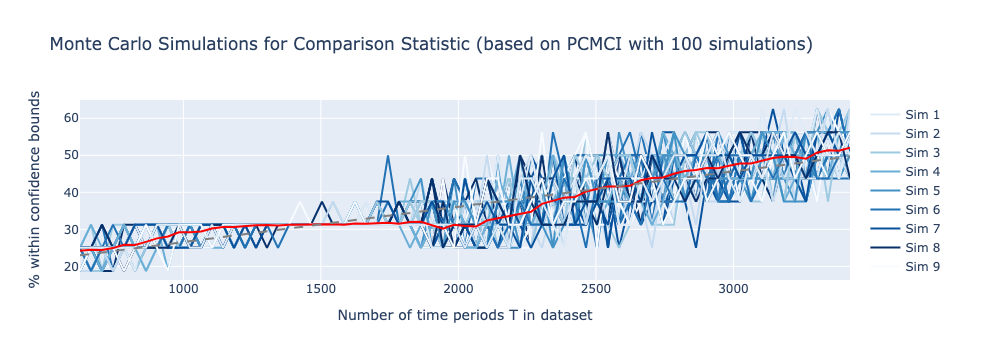

In [180]:
MCstatistics_climate, fig_climate, dataframes_climate, seeds_climate = MonteCarlo_PCMCI_CSgraph(value_matrix_climate, ci_matrix_climate, means_climate, variances_climate, 100, ParCorr(), intervals=40, min_T=624, 
                            max_T=3464, plot_dags=False, seed=None)

In [181]:
CheckDuplicateSeeds(seeds_climate)
# This means we can use it!

Index 25 has 1 duplicates.
Total number of duplicates in the same list index: 1


Now we use the function that combines all functions and put the val_matrix and confidence interval matrix in from the climate data to compare our results to those.

MonteCarlo_CSgraph(mean_val_matrix, ci_matrix, initial_mean, initial_var, M, intervals=50, min_T=50, 
                            max_T=10000, constant_term=False, standard_error_distribution=True, yearly=False, 
                            freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], tau_max=1, boot_samples=200, 
                            boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, seed=None):

returns: 
     MCstatistics, fig, dataframes, seeds

# Results: Monte Carlo Simulations of Random VAR Model

For these results we used a 'confidence matrix' of 0.05 divergence from the original. So we are comparing how much percent is within 0.05 value from the actual causal link.

In [627]:
MCstatistics_VAR, fig_VAR, dataframes_VAR, seeds_VAR = MonteCarlo_PCMCI_CSgraph(value_matrix_VAR, ci_matrix_VAR, means_VAR, variances_VAR, 50, parcorr_conf, intervals=40, min_T=624, 
                            max_T=3464, plot_dags=False, seed=None)

loading... 2.0%
loading... 4.0%
loading... 6.0%
loading... 8.0%
loading... 10.0%
loading... 12.0%
loading... 14.0%
loading... 16.0%
loading... 18.0%
loading... 20.0%
loading... 22.0%
loading... 24.0%
loading... 26.0%
loading... 28.0%
loading... 30.0%
loading... 32.0%
loading... 34.0%
loading... 36.0%
loading... 38.0%
loading... 40.0%
loading... 42.0%
loading... 44.0%
loading... 46.0%
loading... 48.0%
loading... 50.0%
loading... 52.0%
loading... 54.0%
loading... 56.0%
loading... 58.0%
loading... 60.0%
loading... 62.0%
loading... 64.0%
loading... 66.0%
loading... 68.0%
loading... 70.0%
loading... 72.0%
loading... 74.0%
loading... 76.0%
loading... 78.0%
loading... 80.0%
loading... 82.0%
loading... 84.0%
loading... 86.0%
loading... 88.0%
loading... 90.0%
loading... 92.0%
loading... 94.0%
loading... 96.0%
loading... 98.0%
loading... 100.0%


In [630]:
MCstatistics_VAR, fig_VAR, dataframes_VAR, seeds_VAR = MonteCarlo_PCMCI_CSgraph(value_matrix_VAR, ci_matrix_VAR, means_VAR, variances_VAR, 50, parcorr_conf, intervals=40, min_T=624, 
                            max_T=3464, plot_dags=False, seed=None)

TypeError: Run_PCMCI_VAR() got an unexpected keyword argument 'var_names'

The reversed form shows the percentage of the original phi that is within the bounds of the estimated confidence intervals.

loading... 2.0%
loading... 4.0%
loading... 6.0%
loading... 8.0%
loading... 10.0%
loading... 12.0%
loading... 14.0%
loading... 16.0%
loading... 18.0%
loading... 20.0%
loading... 22.0%
loading... 24.0%
loading... 26.0%
loading... 28.0%
loading... 30.0%
loading... 32.0%
loading... 34.0%
loading... 36.0%
loading... 38.0%
loading... 40.0%
loading... 42.0%
loading... 44.0%
loading... 46.0%
loading... 48.0%
loading... 50.0%
loading... 52.0%
loading... 54.0%
loading... 56.0%
loading... 58.0%
loading... 60.0%
loading... 62.0%
loading... 64.0%
loading... 66.0%
loading... 68.0%
loading... 70.0%
loading... 72.0%
loading... 74.0%
loading... 76.0%
loading... 78.0%
loading... 80.0%
loading... 82.0%
loading... 84.0%
loading... 86.0%
loading... 88.0%
loading... 90.0%
loading... 92.0%
loading... 94.0%
loading... 96.0%
loading... 98.0%
loading... 100.0%


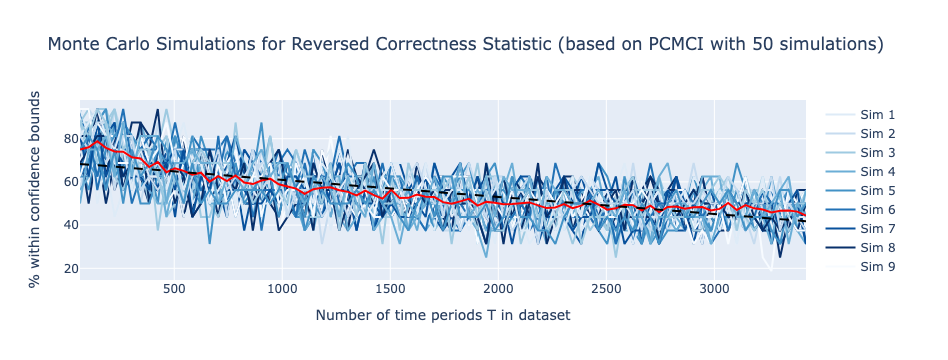

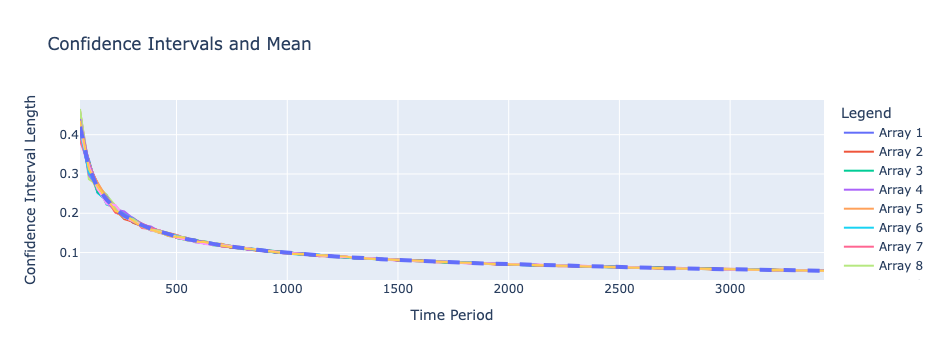

In [628]:
RMCstatistics_VAR, Rfig_VAR, Rdataframes_VAR, Rseeds_VAR, Rmean_bounds_VAR = MonteCarlo_PCMCI_RCSgraph(value_matrix_VAR, means_VAR, variances_VAR, 50, parcorr_conf, intervals=40, min_T=64, 
                            max_T=3464, plot_dags=False, seed=None)
#print("Mean bounds:", Rmean_bounds_VAR)